### Import modules

In [51]:
import networkx as nx
import graph_bandit_RL
from graph_bandit_helper_tools import *
import numpy as np
from known_rewards_helper_functions import get_Q_table
from estimator import NormalBayesianEstimator
from tqdm import trange
from functools import partial
import pickle as pkl

from labellines import labelLines,labelLine


%load_ext autoreload
%autoreload 2

SEED = 181731

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Our algorithm

In [203]:
def visit_all_nodes(gb):
    while True:
        unvisited = [i for i in range(gb.G.number_of_nodes()) if gb.visits[i]==0]

        if len(unvisited)==0:
            break

        dest = unvisited[0]

        next_path = nx.shortest_path(gb.G,gb.state,dest)
        for s in next_path[1:]:
            gb.step(s)

def get_ucb(gb,nodes=None):
    
    if nodes is None:
        nodes = gb.nodes
    ave_reward = [np.mean(gb.nodes[i]['r_hist']) for i in nodes] 
    nm = [gb.visits[i] for i in nodes]
    
    tm = len(gb.visitedStates)
    ucb = ave_reward + 0.5*np.sqrt(2*np.log(tm)/nm)
    
    return ucb


def get_ucb_Q_table(gb):
     
    ucb = get_ucb(gb)
    
    gap = np.sort(list(set(ucb)))[-1]-np.sort(list(set(ucb)))[-2]

    TG = nx.diameter(gb.G)*np.max(ucb)/gap

    Q,k, _ = get_Q_table(gb.G,ucb,TG)
    return Q


In [3]:
def doubling_agent(env):
    ucb = get_ucb(env)
    # Compute Q table.
    Q = get_ucb_Q_table(env)

    # Travel to the node with the highest UCB
    while ucb[env.state] < np.max(ucb):
        next_s = np.argmax(Q[env.state,:])
        env.step(next_s)

    target_count = 0+env.nodes[env.state]['n_visits']
    # Keep sampling the best UCB node until its number of samples doubles
    for _ in range(target_count):
        env.step(env.state)

def local_ucb_agent(env):
    neighbors = [_ for _ in env.G[env.state]]

    neighbor_ucb = get_ucb(env,neighbors)

    best_nb = neighbors[np.argmax(neighbor_ucb)]

    env.step(best_nb)

def local_ts_agent(env,
                    var_0 = 0.5,
                    mu_0 = 2.5,
                    var = 0.5):

    neighbors = [_ for _ in env.G[env.state]]

    # Bayesian estimation of mu and var estimation with Gaussian Prior

    xsum = np.array([np.sum(env.nodes[i]['r_hist']) for i in neighbors])
    n = np.array([env.visits[i] for i in neighbors])

    var_1 = 1/(var_0 + n/var) 
    mu_1 = var_1 * (mu_0/var_0 + xsum/var)

    # Posterior sampling
    mu_sample = np.random.normal(mu_1,np.sqrt(var_1))

    
    # Take a step in the environment
    best_nb = neighbors[np.argmax(mu_sample)]
    env.step(best_nb)
    
def local_greedy_agent(env,
                    epsilon0=1,var_0 = 0.5,
                    mu_0 = 5,
                    var = 0.5):

    neighbors = [_ for _ in env.G[env.state]]
    
    # epsilon = epsilon0 / (len(env.visitedStates)+1)
    epsilon = epsilon0
    
    if np.random.rand()<epsilon:
        env.step(np.random.choice(neighbors))
    else:
         # Bayesian estimation of mu and var estimation with Gaussian Prior

        xsum = np.array([np.sum(env.nodes[i]['r_hist']) for i in neighbors])
        n = np.array([env.visits[i] for i in neighbors])

        var_1 = 1/(var_0 + n/var) 
        mu_1 = var_1 * (mu_0/var_0 + xsum/var)
        
        # Take a step in the environment
        best_nb = neighbors[np.argmax(mu_1)]
        env.step(best_nb)

In [232]:
def train_agent(n_samples,T,G,means, stdevs,init_node,execute_agent, visit_all=True):
    regrets = np.zeros((n_samples,T))
    for i in trange(n_samples):

        env = graph_bandit_RL.GraphBandit(means[i], stdevs[i], G)

        ## Visit all nodes
        if visit_all:
            visit_all_nodes(env)

        H0 = len(env.visitedStates)

        # Start learning

        env.state = init_node

        while len(env.visitedStates)-H0<T:
            execute_agent(env)
            
        # print(len(env.visitedStates),regrets.shape)
            
        regrets[i,:]= env.expectedRegret()[:T]
        
    return regrets

In [8]:
def delta_test(Delta, n_nodes=10, graph_type='line', n_samples=100, T=450):
    np.random.seed(SEED)
    G = return_graph(graph_type, n_nodes)
    
    means = np.zeros((n_samples, n_nodes))
    means[:,0] = [9.5-Delta for _ in range(n_samples)]
    means[:,-1] = [9.5 for _ in range(n_samples)]
    
    stdevs = np.ones(means.shape)
    regrets = train_agent(n_samples,T,G,means,stdevs,init_node,doubling_agent, visit_all=True)
    return regrets

    
    

In [201]:
def num_nodes_test(Delta, n_nodes=10, graph_type='star', n_samples=100, T=450):
    G = return_graph(graph_type, n_nodes)
    print(len(G))
    
    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
    stdevs = np.ones((n_samples,n_nodes))

    regrets = train_agent(n_samples,T,G,means,stdevs,init_node,doubling_agent, visit_all=True)
    return regrets

    
    

In [239]:
T=2000
n_samples = 100
nodes_regrets['$|S|=151$'] = num_nodes_test(0.01, n_nodes=151, graph_type='star', n_samples=n_samples, T=T)

# nodes_regrets['$|S|=401$'] = num_nodes_test(0.01, n_nodes=401, graph_type='star', n_samples=100, T=T)

# nodes_regrets['$|S|=751$'] = num_nodes_test(0.01, n_nodes=751, graph_type='star', n_samples=100, T=T)

# nodes_regrets['$|S|=1001$'] = num_nodes_test(0.01, n_nodes=1001, graph_type='star', n_samples=100, T=T)


151


100%|█████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


In [283]:
def plotRegrets(allRegrets, titles=None, save_fig=None, delta_test=False):
    """
    param allRegrets: list of dictionaries of regrets(samples, time_steps) for various algorithms and runs
    """
    nPlots = len(allRegrets)
    
    plt.style.use('seaborn-whitegrid')
    # sns.set()
    
    labels = {'greedy': 'Local $\epsilon$-greedy', 'thompson': 'Local TS', 'UCB': 'Local UCB','Q_learning': 'Q-learning',\
              'Our Algorithm':'Our Algorithm'}
    styles = {'greedy': 'dotted', 'thompson': 'dotted', 'UCB': 'dotted','Q_learning': 'dashed',\
              'Our Algorithm':'solid'}
    colors = {'greedy': 'b', 'thompson': 'r', 'UCB': 'g','Q_learning': 'm',\
              'Our Algorithm':'k'}
    keys = allRegrets[0].keys()
    if delta_test:
        colors=['b', 'r', 'g', 'm', 'b', 'r', 'g', 'm', 'g', 'c', 'k', 'b', 'r', 'y', 'm', 'g','b']
        styles = ['solid', 'solid', 'solid', 'solid','solid', 'dotted', 'dotted', 'dotted', 'dotted', 'dotted','dotted']
        
    

    if nPlots == 1:
        regrets = allRegrets[0]
        for j, key in enumerate(keys):
            regret = regrets[key]
            regret = np.cumsum(regret, axis=1)
            regret = np.mean(regret, axis=0)
            if not delta_test:
                plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[key], linestyle = styles[key], label=labels[key],\
                        linewidth=3)
            else:
                plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[j], linestyle = styles[j], label=key,\
                        linewidth=3)
        if titles is not None:    
            plt.title(titles[0])
    else:
        fig, axes = plt.subplots(2, 3, figsize=(17,10))
        for j, regrets in enumerate(allRegrets):
            for i, key in enumerate(regrets.keys()):
                regret = regrets[key]
                regret = np.cumsum(regret, axis=1)
                df = pd.DataFrame(np.transpose(regret))
                df.columns = [labels[key] for _ in range(regret.shape[0])]
                if j<3:
                    sns.lineplot(ax = axes[0,j], data=df, ci=None, palette=[colors[key]])
                    axes[0,j].set_title(titles[j])
                else:
                    sns.lineplot(ax = axes[1,j%3], data=df, ci=None, palette=[colors[key]])
                    axes[1,j%3].set_title(titles[j])
    if delta_test:
        # plt.legend(loc='lower right', ncol=2, bbox_to_anchor=(1.895,0.42), fontsize=16)
        # labelLines(plt.gca().get_lines(),align=False, zorder=2.5)
        pass
    else:
        plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
        
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('Regret', fontsize=20)
    plt.tick_params(labelsize=20)
    if save_fig is not None:
        plt.savefig('Figures/'+save_fig, bbox_inches = 'tight')
    # plt.show()
    
    

<>:10: DeprecationWarning: invalid escape sequence \e


### Define parameters

Define the following parameters:  
$\texttt{T}:$ game length  
$\texttt{n_samples}:$ number of games to run   
$\texttt{episodes}:$ number of episodes; Let this be 1 for now 
$\texttt{n_nodes}:$ number of nodes in graph. 
$\texttt{mu_size}:$ the node means are drawn as $\mu\sim \texttt{mu_size}\times \mathcal{N}(0,1)$   
$\texttt{sigma_size}:$ the node standard deviations are set to $\texttt{sigma_size}$ 
$\texttt{epsilon}:$ exploration parameter (only applicable for Q-learning algorithms)  
$\texttt{epsilon_discount}:$ exploration discount parameter (only applicable for Q-learning algorithms)  
$\texttt{algorithms}:$ the algorithms to run. 


 



In [11]:
T = 2000
n_samples = 100
episodes = 1
n_nodes = 10
mu_size = 1
sigma_size = 1

# For Q-learning

epsilon = 0.9
epsilon_discount=0.99

init_node = 0

In [30]:
delta_regrets = {}
delta_regrets['$\Delta=2$'] = delta_test(2, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=1$'] = delta_test(1, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=0.5$'] = delta_test(0.5, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=0.25$'] = delta_test(0.25, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=10^{-1}$'] = delta_test(0.1, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=10^{-2}$'] = delta_test(0.01, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=10^{-3}$'] = delta_test(0.001, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=10^{-4}$'] = delta_test(0.0001, n_nodes=10, graph_type='line', n_samples=100, T=1000)

<>:2: DeprecationWarning: invalid escape sequence \D
100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.19it/s]


In [ ]:
nodes_regrets = {}

In [ ]:
Ns = [11,31,71,101,201]
n_samples = 100
T = 2000

np.random.seed(SEED)
for n_nodes in Ns:
    nodes_regrets['$|S|={}$'.format(n_nodes)] = num_nodes_test(0.01, n_nodes=n_nodes, graph_type='star', n_samples=n_samples, T=T)

100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


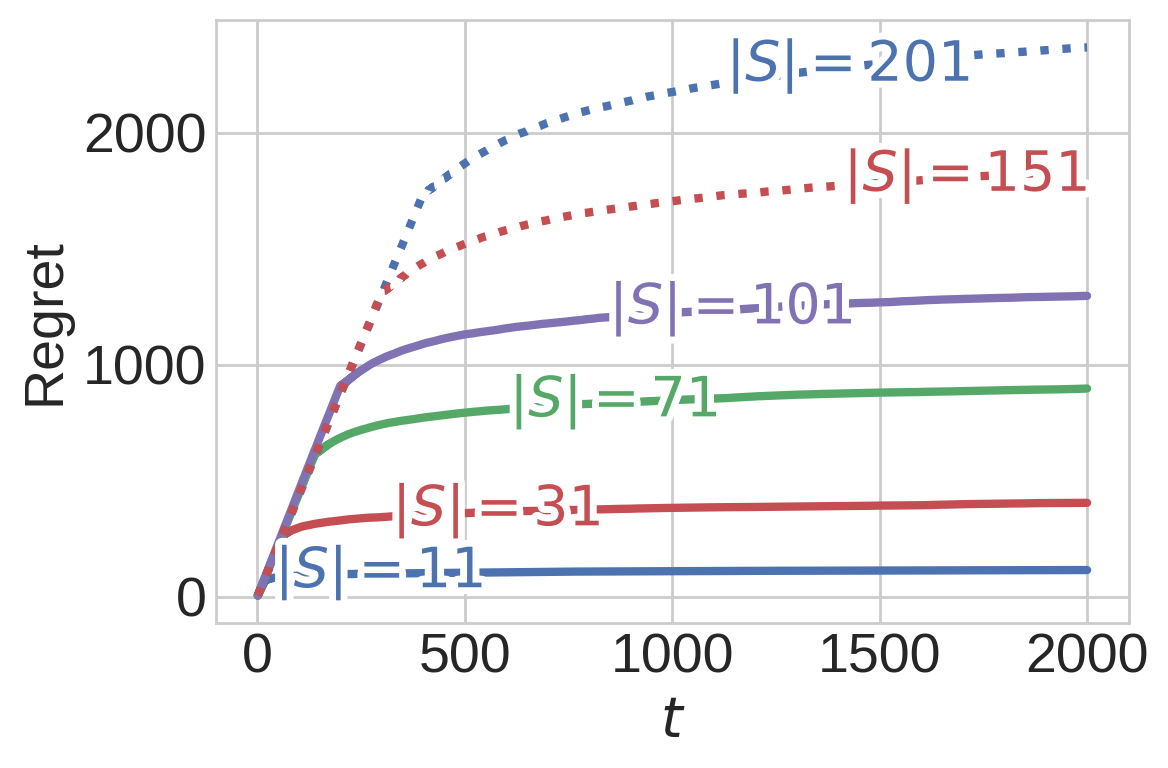

In [249]:
# plotRegrets([nodes_regrets], delta_test=True, save_fig='num_node_test')



plt.figure(dpi=200)
plotRegrets([nodes_regrets], delta_test=True)

lines = plt.gca().get_lines()

labelLines(lines[:],align=False, zorder=2.5,fontsize=20)
plt.tight_layout()
plt.savefig('Figures/num_node_test.png')
plt.show()

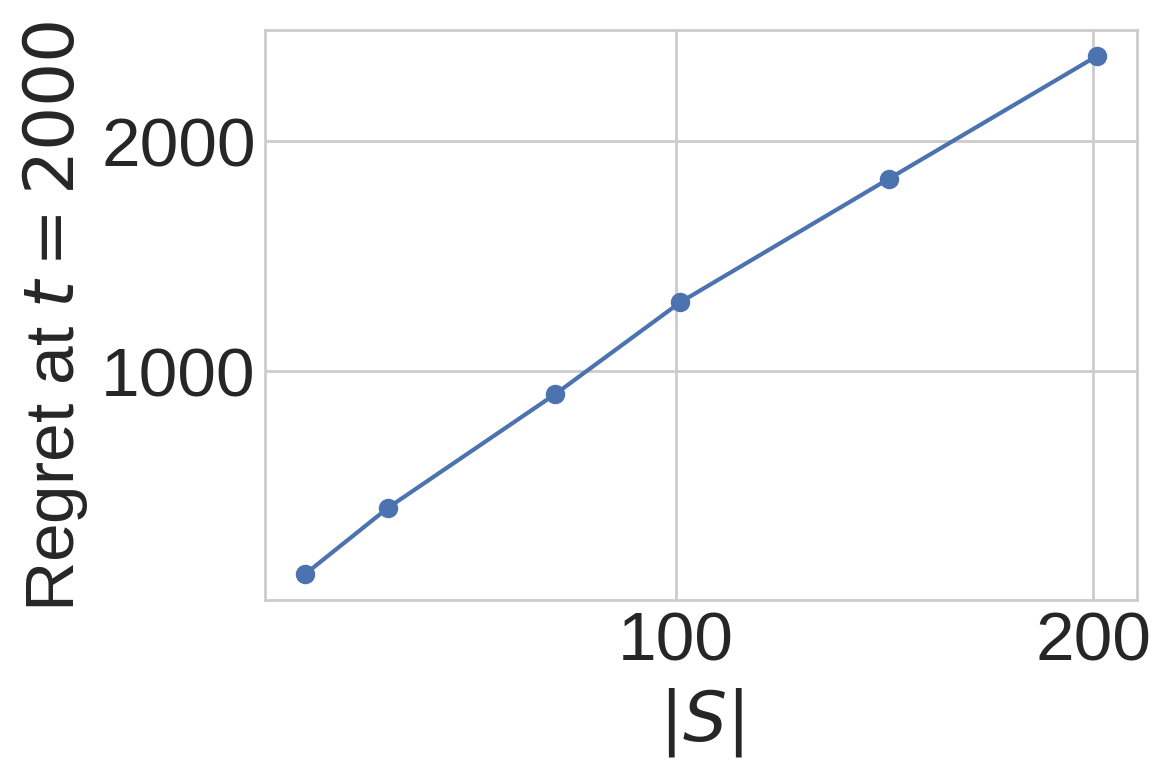

In [247]:
num_nodes = [11,31,71,101,151,201]

reg = [nodes_regrets["$|S|={}$".format(n)] for n in num_nodes]

reg = np.cumsum(reg, axis=2)
reg = np.mean(reg, axis=1)

plt.figure(dpi=200)

plt.plot(num_nodes,reg[:,-1],marker='o')
plt.xlabel(r"$|S|$",fontsize=25)
plt.ylabel(r'Regret at $t=2000$',fontsize=25)
plt.tick_params(labelsize=25)

plt.tight_layout()
plt.savefig('Figures/Rvs|S|.png')

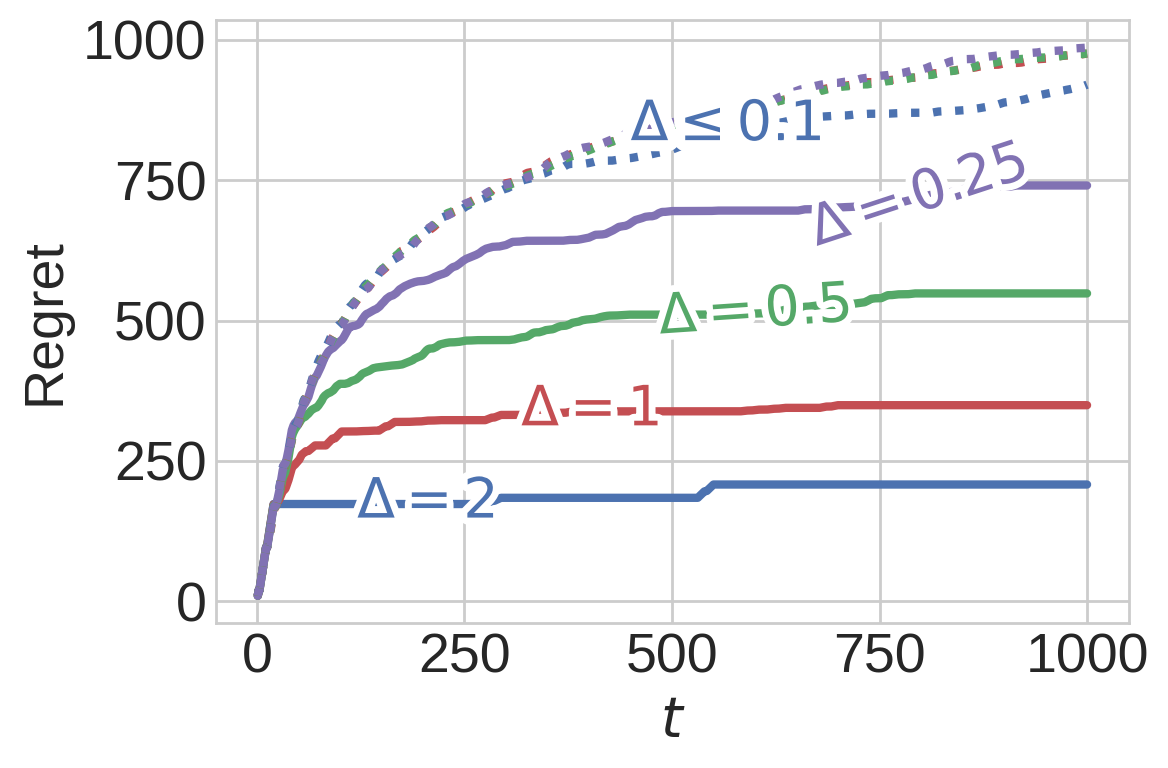

In [ ]:
plt.figure(dpi=200)

plotRegrets([delta_regrets], delta_test=True)#

lines = plt.gca().get_lines()

labelLine(
    lines[-4],
    450,
    label=r"$\Delta\leq 0.1$",
    ha="left",
    va="bottom",
    align=False,
    yoffset = 10,
    backgroundcolor="none",
   fontsize = 20
)


labelLines(lines[:-4],align=True, zorder=2.5,fontsize=20)


# labelLines(lines[-4:],align=False, zorder=2.5)

plt.tight_layout()
plt.savefig('Figures/delta_test.png',bbox_inches = 'tight')
plt.show()

In [162]:
with open('Data/delta_test.pkl', 'wb') as file:
    pkl.dump(delta_regrets,file)

In [245]:
with open('Data/num_node_test.pkl', 'wb') as file:
    pkl.dump(nodes_regrets,file)

In [339]:
# Fixed diameter graphs

def fix_diameter_graph(N,D):
    assert(D<=N)
    
    if D==1:
        return return_graph('fully_connected',N)
    
    G = return_graph('line',D)
    G.add_edges_from([(D-1, i+D) for i in range(N-D)])
    G.add_edges_from([(i,i) for i in G])
    return G

In [312]:
reg = {}

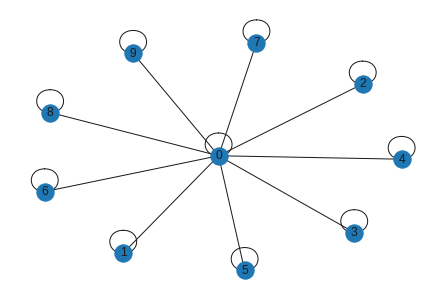

In [338]:
draw_graph(fix_diameter_graph(10,1))

In [318]:
n_nodes = 50
n_samples = 100

T=2000

init_node = 0

Ds = range(2,n_nodes+2,4)

for d in Ds:
    G = fix_diameter_graph(n_nodes,d)

    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
    stdevs = np.ones((n_samples,n_nodes))

    regrets = train_agent(n_samples,T,G,means,stdevs,init_node,doubling_agent, visit_all=True)
    
    reg['$D={}$'.format(d)]=regrets

100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


In [340]:
d = 1
G = fix_diameter_graph(n_nodes,d)

means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

regrets = train_agent(n_samples,T,G,means,stdevs,init_node,doubling_agent, visit_all=True)

reg['$D={}$'.format(d)]=regrets

100%|█████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


In [341]:
with open('Data/D_test.pkl', 'wb') as file:
    pkl.dump(reg,file)

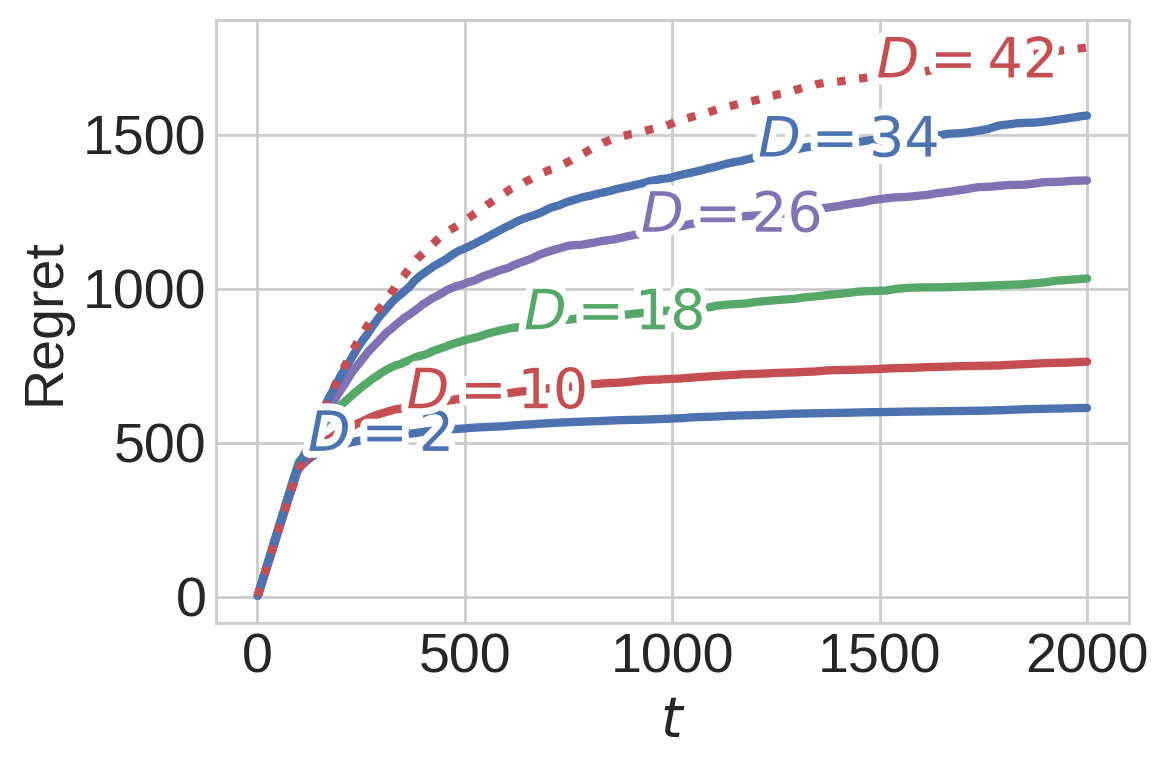

In [342]:
plt.figure(dpi=200)
to_plot = {'$D={}$'.format(i):reg['$D={}$'.format(i)] for i in Ds[:-1]}

plotRegrets([to_plot],delta_test=True)

lines = plt.gca().get_lines()


labelLines(lines,align=False, zorder=2.5,fontsize=20)


plt.tight_layout()
plt.savefig('Figures/D_test.png')

plt.show()

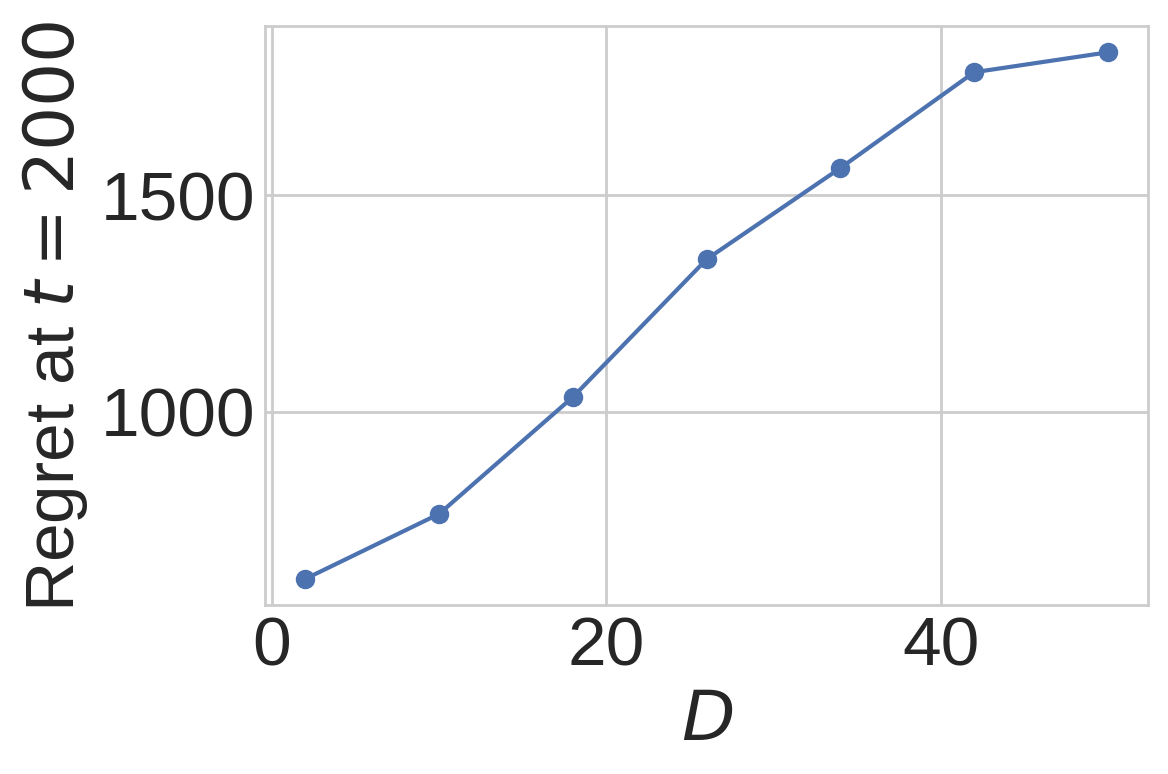

In [347]:

to_plot_D = list(range(2,n_nodes+2,8))
R = [reg['$D={}$'.format(d)] for d in to_plot_D]
R = np.cumsum(R, axis=2)
R = np.mean(R, axis=1)

plt.figure(dpi=200)

plt.plot(to_plot_D,R[:,-1],marker='o')
plt.xlabel(r"$D$",fontsize=25)
plt.ylabel(r'Regret at $t=2000$',fontsize=25)
plt.tick_params(labelsize=25)

plt.tight_layout()
plt.savefig('Figures/RvsD.png')
plt.show()